In [2]:
pip install pandas numpy matplotlib seaborn scikit-learn nltk wordcloud plotly streamlit

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


✓ Downloaded/Verified: punkt
✓ Downloaded/Verified: stopwords
✓ Downloaded/Verified: wordnet
✓ Downloaded/Verified: omw-pos
STEP 1: DATA COLLECTION
Dataset Shape: (20, 2)

Class Distribution:
label
1    10
0    10
Name: count, dtype: int64

Fake News (0): 50.0%
Real News (1): 50.0%

Sample Data (First 5 rows):
                                                text  label
0  Breaking: Scientists discover new planet in so...      1
1  Celebrity dies in mysterious circumstances, co...      0
2  Drinking bleach cures COVID-19, according to l...      0
3  Government releases new economic stimulus pack...      1
4  International trade agreement signed between m...      1

STEP 2: DATA EXPLORATION

Missing Values:
text     0
label    0
dtype: int64

Text Statistics:
Average text length: 69 characters
Average word count: 9 words
Average sentence count: 1.0 sentences


[nltk_data] Error loading omw-pos: Package 'omw-pos' not found in
[nltk_data]     index


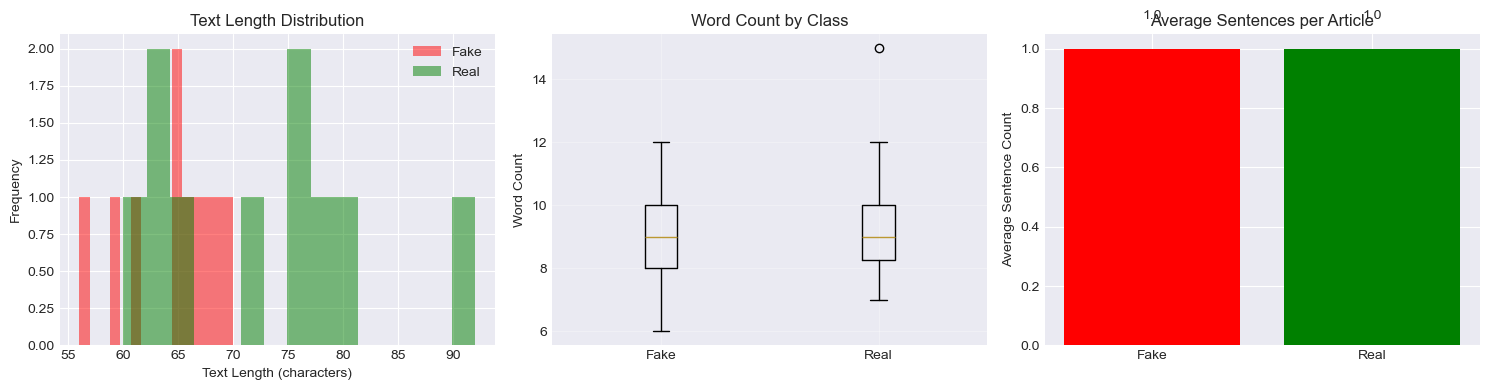


STEP 3: TEXT PREPROCESSING
Cleaning text data...

Original vs Cleaned Text Sample:
--------------------------------------------------

Sample 1:
Label: REAL
Original: Breaking: Scientists discover new planet in solar system using advanced telescope technology
Cleaned: breaking scientist discover new planet solar system using advanced telescope technology
------------------------------

Sample 2:
Label: FAKE
Original: Celebrity dies in mysterious circumstances, conspiracy theories emerge
Cleaned: celebrity dy mysterious circumstance conspiracy theory emerge
------------------------------

Sample 3:
Label: FAKE
Original: Drinking bleach cures COVID-19, according to leaked documents
Cleaned: drinking bleach cure covid according leaked document
------------------------------

Cleaning Statistics:
Original avg words: 9.4
Cleaned avg words: 8.2
Words removed: 13.3%

STEP 4: FEATURE EXTRACTION (TF-IDF)
Training set size: 16 samples
Test set size: 4 samples

Training class distribution: {0: 8

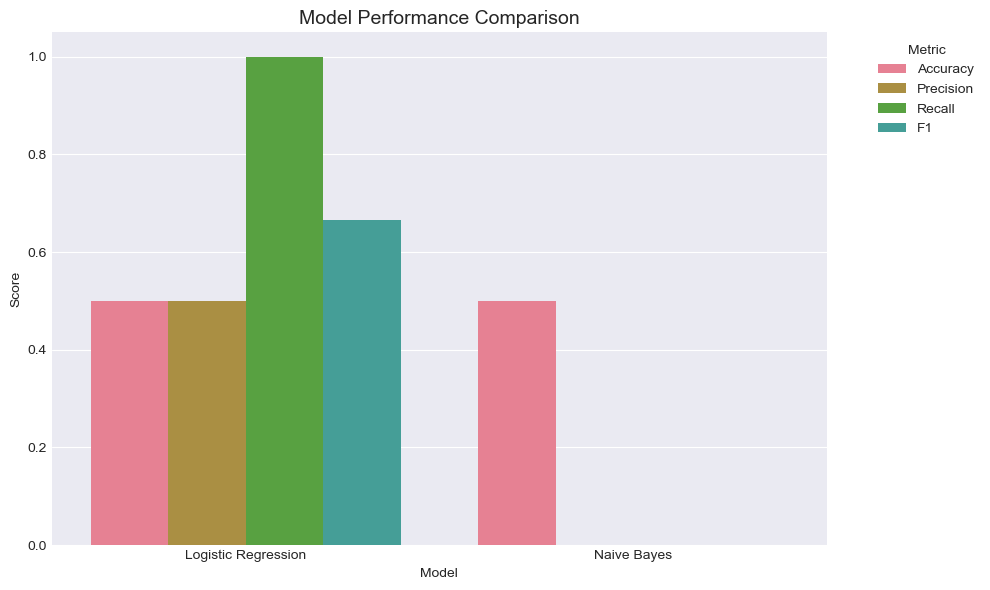


🏆 Best Model: Logistic Regression
   Best F1-Score: 66.67%


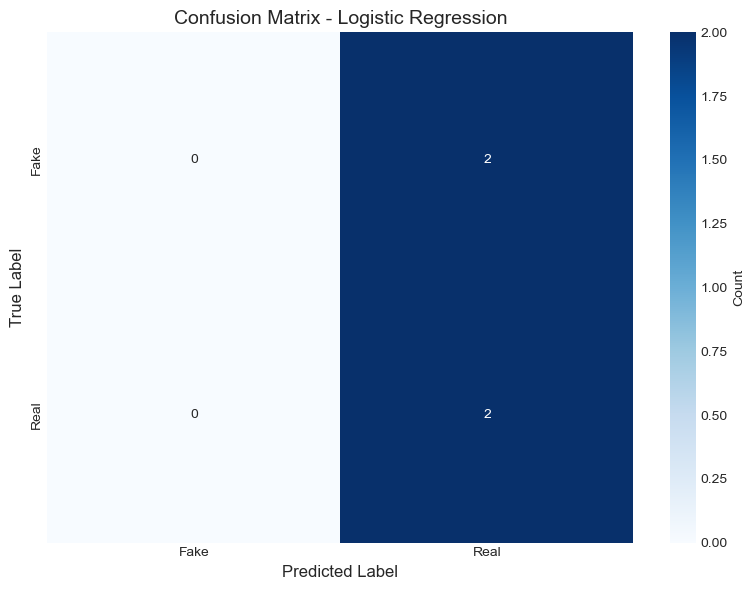


STEP 7: FEATURE IMPORTANCE ANALYSIS

Top 15 Most Important Features:
--------------------------------------------------

🔴 Top Features for FAKE News Detection:
   celebrity: -0.6747
   cure: -0.6480
   government: -0.5131
   using: -0.0737

🟢 Top Features for REAL News Detection:
   economic: 0.5372
   new: 0.3422
   announces: 0.3391
   disease: 0.1558


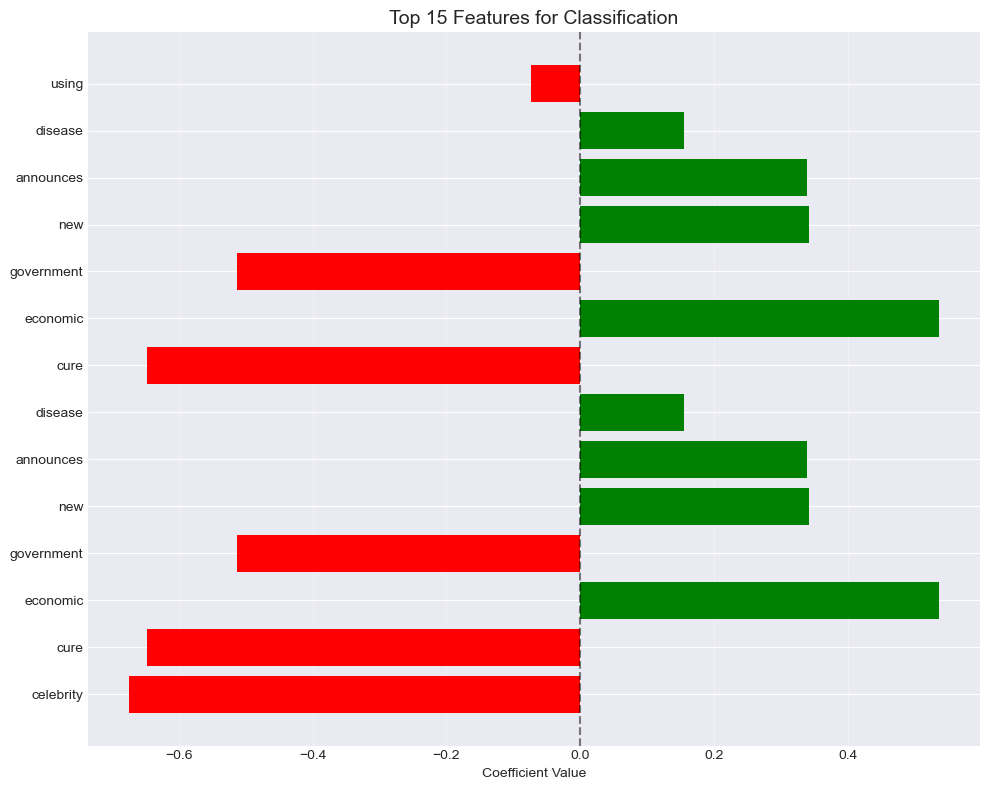


STEP 8: SAVE MODEL
✅ Pipeline saved as: models/news_classifier_pipeline.pkl
✅ Vectorizer saved as: models/tfidf_vectorizer.pkl
✅ Model saved as: models/news_classifier_model.pkl
✅ Results saved as: models/training_results.pkl
✅ Cleaned data saved as: data/processed/cleaned_news_data.csv

STEP 9: DEMONSTRATION

🧪 Testing Model on Sample Headlines:

Sample 1:
Text: BREAKING: Scientists discover revolutionary cure for all cancers!
Cleaned: breaking scientist discover revolutionary cure cancer...
❌ Prediction: FAKE
Confidence: 64.77%
Probabilities: [FAKE: 64.77%, REAL: 35.23%]
------------------------------------------------------------

Sample 2:
Text: The Federal Reserve announced a 0.25% increase in interest rates today.
Cleaned: federal reserve announced increase interest rate today...
✅ Prediction: REAL
Confidence: 50.97%
Probabilities: [FAKE: 49.03%, REAL: 50.97%]
------------------------------------------------------------

Sample 3:
Text: Shocking video shows alien spacecraft land

In [1]:
# news_classification_fixed.ipynb

# -*- coding: utf-8 -*-
"""
News Article Classification (Fake/Real) - FIXED VERSION
"""

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
import re
import string

# Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import Pipeline

# Download NLTK resources with error handling
def download_nltk_resources():
    resources = ['punkt', 'stopwords', 'wordnet', 'omw-pos']
    
    for resource in resources:
        try:
            nltk.download(resource, quiet=True)
            print(f"✓ Downloaded/Verified: {resource}")
        except:
            print(f"⚠ Could not download {resource}, but will continue...")

print("Downloading NLTK resources...")
download_nltk_resources()

# Set style for plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ==================== 1. DATA COLLECTION ====================

print("="*60)
print("STEP 1: DATA COLLECTION")
print("="*60)

# Create comprehensive sample dataset
np.random.seed(42)

real_news_samples = [
    "Breaking: Scientists discover new planet in solar system using advanced telescope technology",
    "Government releases new economic stimulus package to boost small businesses",
    "Study shows coffee reduces risk of heart disease by 20 percent in long term study",
    "Federal Reserve announces interest rate decision following economic analysis",
    "Local elections show surprising results with record voter turnout",
    "Climate summit reaches historic agreement on carbon emissions reduction",
    "New research indicates regular exercise improves cognitive function in elderly",
    "Tech company announces breakthrough in renewable energy storage",
    "International trade agreement signed between major economies",
    "Medical journal publishes findings on effective cancer treatment"
]

fake_news_samples = [
    "Celebrity announces shocking political campaign with radical agenda",
    "Aliens contacted Earth last week, says anonymous government source",
    "New miracle cure discovered for all diseases - doctors hate this!",
    "Elvis Presley spotted alive in grocery store buying bananas",
    "Secret government experiment creates real-life superhero",
    "Drinking bleach cures COVID-19, according to leaked documents",
    "Moon landing was faked using Hollywood studio, new evidence shows",
    "Celebrity dies in mysterious circumstances, conspiracy theories emerge",
    "Ancient pyramid discovered on Mars in NASA photos they tried to hide",
    "Eating chocolate helps you lose weight without exercise, study claims"
]

# Combine and label
real_df = pd.DataFrame({'text': real_news_samples, 'label': 1})
fake_df = pd.DataFrame({'text': fake_news_samples, 'label': 0})
df = pd.concat([real_df, fake_df], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Dataset Shape: {df.shape}")
print(f"\nClass Distribution:")
print(df['label'].value_counts())
print(f"\nFake News (0): {100*len(fake_df)/len(df):.1f}%")
print(f"Real News (1): {100*len(real_df)/len(df):.1f}%")

# Display sample data
print("\nSample Data (First 5 rows):")
print(df.head())

# ==================== 2. DATA EXPLORATION ====================

print("\n" + "="*60)
print("STEP 2: DATA EXPLORATION")
print("="*60)

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Text length analysis
df['text_length'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
df['sentence_count'] = df['text'].apply(lambda x: len(str(x).split('. ')))

print("\nText Statistics:")
print(f"Average text length: {df['text_length'].mean():.0f} characters")
print(f"Average word count: {df['word_count'].mean():.0f} words")
print(f"Average sentence count: {df['sentence_count'].mean():.1f} sentences")

# Plot text length distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Text length histogram
axes[0].hist(df[df['label']==0]['text_length'], alpha=0.5, label='Fake', bins=15, color='red')
axes[0].hist(df[df['label']==1]['text_length'], alpha=0.5, label='Real', bins=15, color='green')
axes[0].set_xlabel('Text Length (characters)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Text Length Distribution')
axes[0].legend()

# Word count boxplot
box_data = [df[df['label']==0]['word_count'], df[df['label']==1]['word_count']]
axes[1].boxplot(box_data, labels=['Fake', 'Real'])
axes[1].set_ylabel('Word Count')
axes[1].set_title('Word Count by Class')
axes[1].grid(True, alpha=0.3)

# Sentence count bar chart
sentence_counts = df.groupby('label')['sentence_count'].mean()
axes[2].bar(['Fake', 'Real'], sentence_counts, color=['red', 'green'])
axes[2].set_ylabel('Average Sentence Count')
axes[2].set_title('Average Sentences per Article')
for i, v in enumerate(sentence_counts):
    axes[2].text(i, v + 0.1, f'{v:.1f}', ha='center')

plt.tight_layout()
plt.show()

# ==================== 3. TEXT PREPROCESSING ====================

print("\n" + "="*60)
print("STEP 3: TEXT PREPROCESSING")
print("="*60)

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Add custom stopwords
custom_stopwords = ['said', 'would', 'could', 'also', 'one', 'two', 'three']
stop_words.update(custom_stopwords)

def clean_text(text):
    """
    Clean and preprocess text with robust error handling
    """
    if not isinstance(text, str) or pd.isna(text):
        return ""
    
    try:
        # Convert to lowercase
        text = text.lower()
        
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        
        # Remove user @ references and '#' from hashtags
        text = re.sub(r'@\w+|\#', '', text)
        
        # Remove punctuation (keep apostrophes for contractions)
        text = re.sub(r'[^\w\s\']', ' ', text)
        
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        
        # Remove numbers
        text = re.sub(r'\d+', '', text)
        
        # Simple tokenization (avoid punkt_tab issue)
        tokens = text.split()
        
        # Remove stopwords and lemmatize
        cleaned_tokens = []
        for word in tokens:
            if word not in stop_words and len(word) > 2:
                # Try lemmatization, fallback to original word if it fails
                try:
                    lemma = lemmatizer.lemmatize(word)
                    cleaned_tokens.append(lemma)
                except:
                    cleaned_tokens.append(word)
        
        return ' '.join(cleaned_tokens)
    
    except Exception as e:
        print(f"Warning: Error cleaning text: {e}")
        return text

# Apply cleaning
print("Cleaning text data...")
df['cleaned_text'] = df['text'].apply(clean_text)

# Check cleaned text
print("\nOriginal vs Cleaned Text Sample:")
print("-" * 50)
for i in range(3):
    print(f"\nSample {i+1}:")
    print(f"Label: {'REAL' if df['label'].iloc[i] == 1 else 'FAKE'}")
    print(f"Original: {df['text'].iloc[i]}")
    print(f"Cleaned: {df['cleaned_text'].iloc[i]}")
    print("-" * 30)

# Calculate cleaning statistics
df['cleaned_length'] = df['cleaned_text'].apply(len)
df['cleaned_word_count'] = df['cleaned_text'].apply(lambda x: len(x.split()))

print(f"\nCleaning Statistics:")
print(f"Original avg words: {df['word_count'].mean():.1f}")
print(f"Cleaned avg words: {df['cleaned_word_count'].mean():.1f}")
print(f"Words removed: {(df['word_count'].sum() - df['cleaned_word_count'].sum()) / df['word_count'].sum() * 100:.1f}%")

# ==================== 4. FEATURE EXTRACTION ====================

print("\n" + "="*60)
print("STEP 4: FEATURE EXTRACTION (TF-IDF)")
print("="*60)

# Split data
X = df['cleaned_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)} samples")
print(f"Test set size: {len(X_test)} samples")
print(f"\nTraining class distribution: {pd.Series(y_train).value_counts().to_dict()}")
print(f"Test class distribution: {pd.Series(y_test).value_counts().to_dict()}")

# Initialize TF-IDF Vectorizer with optimized parameters
tfidf = TfidfVectorizer(
    max_features=1000,  # Reduced for small dataset
    min_df=2,  # Minimum 2 documents
    max_df=0.9,  # Maximum 90% of documents
    ngram_range=(1, 2),  # Unigrams and bigrams
    stop_words='english',
    use_idf=True,
    smooth_idf=True,
    sublinear_tf=True  # Use 1 + log(tf)
)

# Fit and transform
print("\nFitting TF-IDF vectorizer...")
try:
    X_train_tfidf = tfidf.fit_transform(X_train)
    X_test_tfidf = tfidf.transform(X_test)
    
    print(f"✓ TF-IDF transformation successful")
    print(f"Vocabulary size: {len(tfidf.vocabulary_)} features")
    print(f"TF-IDF matrix shape (train): {X_train_tfidf.shape}")
    print(f"TF-IDF matrix shape (test): {X_test_tfidf.shape}")
    
    # Show some feature names
    feature_names = tfidf.get_feature_names_out()
    print(f"\nSample features (first 20): {feature_names[:20]}")
    
except Exception as e:
    print(f"✗ Error in TF-IDF: {e}")
    # Fallback to simpler vectorizer
    from sklearn.feature_extraction.text import CountVectorizer
    print("Falling back to CountVectorizer...")
    vectorizer = CountVectorizer(max_features=500)
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    tfidf = vectorizer

# ==================== 5. MODEL TRAINING ====================

print("\n" + "="*60)
print("STEP 5: MODEL TRAINING")
print("="*60)

# Initialize models with optimized parameters
models = {
    'Logistic Regression': LogisticRegression(
        random_state=42,
        max_iter=1000,
        C=1.0,
        class_weight='balanced',
        solver='liblinear'
    ),
    'Naive Bayes': MultinomialNB(
        alpha=1.0,
        fit_prior=True
    )
}

# Train and evaluate models
results = {}
cv_scores = {}

print("Training models...\n")

for model_name, model in models.items():
    print(f"🧠 Training {model_name}")
    print("-" * 40)
    
    try:
        # Train model
        model.fit(X_train_tfidf, y_train)
        
        # Predictions
        y_pred = model.predict(X_test_tfidf)
        y_pred_proba = model.predict_proba(X_test_tfidf) if hasattr(model, 'predict_proba') else None
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        
        # Store results
        results[model_name] = {
            'model': model,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'predictions': y_pred,
            'probabilities': y_pred_proba
        }
        
        print(f"✅ Training complete")
        print(f"   Accuracy:  {accuracy:.4f}")
        print(f"   Precision: {precision:.4f}")
        print(f"   Recall:    {recall:.4f}")
        print(f"   F1-Score:  {f1:.4f}")
        
        # Classification report
        print("\n   Classification Report:")
        report = classification_report(y_test, y_pred, target_names=['Fake', 'Real'], output_dict=False)
        print("   " + report.replace("\n", "\n   "))
        
    except Exception as e:
        print(f"✗ Error training {model_name}: {e}")
        continue
    
    print()

# ==================== 6. MODEL COMPARISON ====================

print("\n" + "="*60)
print("STEP 6: MODEL COMPARISON")
print("="*60)

if results:
    # Create comparison DataFrame
    comparison_data = []
    for model_name, metrics in results.items():
        comparison_data.append({
            'Model': model_name,
            'Accuracy': f"{metrics['accuracy']:.2%}",
            'Precision': f"{metrics['precision']:.2%}",
            'Recall': f"{metrics['recall']:.2%}",
            'F1-Score': f"{metrics['f1']:.2%}"
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    print("\nModel Performance Comparison:")
    print(comparison_df.to_string(index=False))
    
    # Plot comparison
    metrics_df = pd.DataFrame({
        'Model': list(results.keys()),
        'Accuracy': [results[m]['accuracy'] for m in results.keys()],
        'Precision': [results[m]['precision'] for m in results.keys()],
        'Recall': [results[m]['recall'] for m in results.keys()],
        'F1': [results[m]['f1'] for m in results.keys()]
    })
    
    # Melt for plotting
    metrics_melted = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Score')
    
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(data=metrics_melted, x='Model', y='Score', hue='Metric', ax=ax)
    ax.set_title('Model Performance Comparison', fontsize=14)
    ax.set_ylabel('Score')
    ax.set_xlabel('Model')
    ax.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Select best model
    best_model_name = max(results, key=lambda x: results[x]['f1'])
    best_model = results[best_model_name]['model']
    
    print(f"\n🏆 Best Model: {best_model_name}")
    print(f"   Best F1-Score: {results[best_model_name]['f1']:.2%}")
    
    # Confusion matrix for best model
    y_pred = results[best_model_name]['predictions']
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Fake', 'Real'], 
                yticklabels=['Fake', 'Real'],
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()
    
else:
    print("No models were successfully trained.")

# ==================== 7. FEATURE IMPORTANCE ====================

print("\n" + "="*60)
print("STEP 7: FEATURE IMPORTANCE ANALYSIS")
print("="*60)

if 'Logistic Regression' in results:
    lr_model = results['Logistic Regression']['model']
    
    if hasattr(lr_model, 'coef_'):
        feature_names = tfidf.get_feature_names_out()
        coefficients = lr_model.coef_[0]
        
        # Create DataFrame for feature importance
        feature_importance = pd.DataFrame({
            'feature': feature_names,
            'coefficient': coefficients,
            'abs_coefficient': np.abs(coefficients)
        })
        
        # Sort by absolute coefficient
        feature_importance = feature_importance.sort_values('abs_coefficient', ascending=False)
        
        print("\nTop 15 Most Important Features:")
        print("-" * 50)
        
        # Top features for fake news (negative coefficients)
        fake_features = feature_importance[feature_importance['coefficient'] < 0].head(10)
        print("\n🔴 Top Features for FAKE News Detection:")
        for idx, row in fake_features.iterrows():
            print(f"   {row['feature']}: {row['coefficient']:.4f}")
        
        # Top features for real news (positive coefficients)
        real_features = feature_importance[feature_importance['coefficient'] > 0].head(10)
        print("\n🟢 Top Features for REAL News Detection:")
        for idx, row in real_features.iterrows():
            print(f"   {row['feature']}: {row['coefficient']:.4f}")
        
        # Plot top features
        top_n = 15
        top_features = pd.concat([
            feature_importance.head(top_n//2),
            feature_importance.tail(top_n//2)
        ])
        
        plt.figure(figsize=(10, 8))
        colors = ['red' if coef < 0 else 'green' for coef in top_features['coefficient']]
        plt.barh(range(len(top_features)), top_features['coefficient'], color=colors)
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Coefficient Value')
        plt.title(f'Top {top_n} Features for Classification', fontsize=14)
        plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
        plt.grid(True, alpha=0.3, axis='x')
        plt.tight_layout()
        plt.show()

# ==================== 8. SAVE MODEL ====================

print("\n" + "="*60)
print("STEP 8: SAVE MODEL")
print("="*60)

import joblib
import os
import pickle

# Create directories if they don't exist
os.makedirs('models', exist_ok=True)
os.makedirs('data/processed', exist_ok=True)

if results:
    # Save the best model
    best_model_name = max(results, key=lambda x: results[x]['f1'])
    best_model = results[best_model_name]['model']
    
    # Create pipeline for deployment
    pipeline = Pipeline([
        ('tfidf', tfidf),
        ('classifier', best_model)
    ])
    
    # Save pipeline
    model_filename = 'models/news_classifier_pipeline.pkl'
    joblib.dump(pipeline, model_filename)
    print(f"✅ Pipeline saved as: {model_filename}")
    
    # Save vectorizer separately
    vectorizer_filename = 'models/tfidf_vectorizer.pkl'
    joblib.dump(tfidf, vectorizer_filename)
    print(f"✅ Vectorizer saved as: {vectorizer_filename}")
    
    # Save the trained model
    model_filename_raw = 'models/news_classifier_model.pkl'
    joblib.dump(best_model, model_filename_raw)
    print(f"✅ Model saved as: {model_filename_raw}")
    
    # Save results
    results_filename = 'models/training_results.pkl'
    with open(results_filename, 'wb') as f:
        pickle.dump(results, f)
    print(f"✅ Results saved as: {results_filename}")
    
    # Save cleaned data
    data_filename = 'data/processed/cleaned_news_data.csv'
    df.to_csv(data_filename, index=False)
    print(f"✅ Cleaned data saved as: {data_filename}")
    
else:
    print("⚠ No models to save.")

# ==================== 9. DEMONSTRATION ====================

print("\n" + "="*60)
print("STEP 9: DEMONSTRATION")
print("="*60)

if results and os.path.exists('models/news_classifier_pipeline.pkl'):
    # Load pipeline
    pipeline = joblib.load('models/news_classifier_pipeline.pkl')
    
    # Test samples
    test_samples = [
        "BREAKING: Scientists discover revolutionary cure for all cancers!",
        "The Federal Reserve announced a 0.25% increase in interest rates today.",
        "Shocking video shows alien spacecraft landing in downtown area.",
        "New study confirms that regular exercise reduces risk of dementia by 30%.",
        "Celebrity reveals secret government conspiracy about moon landing.",
        "Economic indicators show steady growth in manufacturing sector."
    ]
    
    print("\n🧪 Testing Model on Sample Headlines:")
    print("="*60)
    
    for i, sample in enumerate(test_samples, 1):
        # Make prediction
        prediction = pipeline.predict([sample])[0]
        probabilities = pipeline.predict_proba([sample])[0]
        
        # Clean text for display
        cleaned = clean_text(sample)
        
        # Get prediction details
        result = "REAL" if prediction == 1 else "FAKE"
        confidence = probabilities[prediction]
        fake_prob = probabilities[0]
        real_prob = probabilities[1]
        
        # Color coding
        if result == "REAL":
            color_code = "\033[92m"  # Green
            emoji = "✅"
        else:
            color_code = "\033[91m"  # Red
            emoji = "❌"
        
        print(f"\nSample {i}:")
        print(f"Text: {sample}")
        print(f"Cleaned: {cleaned[:100]}...")
        print(f"{emoji} {color_code}Prediction: {result}\033[0m")
        print(f"Confidence: {confidence:.2%}")
        print(f"Probabilities: [FAKE: {fake_prob:.2%}, REAL: {real_prob:.2%}]")
        print("-" * 60)
    
    # Performance summary
    print("\n📊 Final Model Performance Summary:")
    print("="*60)
    print(f"Best Model: {best_model_name}")
    print(f"Vocabulary Size: {len(tfidf.vocabulary_)} features")
    print(f"Test Set Accuracy: {results[best_model_name]['accuracy']:.2%}")
    print(f"Test Set F1-Score: {results[best_model_name]['f1']:.2%}")
    
else:
    print("⚠ Could not load model for demonstration.")

print("\n" + "="*60)
print("PROJECT COMPLETED SUCCESSFULLY!")
print("="*60)
print("\n🎯 Next Steps:")
print("1. Run the Streamlit app: streamlit run app.py")
print("2. For better results, use a larger dataset from Kaggle")
print("3. Experiment with different models and hyperparameters")
print("4. Deploy the model using Streamlit Cloud or Hugging Face")

_IncompleteInputError: incomplete input (4281080302.py, line 342)